In [1]:
from __future__ import annotations
from typing import List

In [2]:
__author__ = "Marco Sanguineti"
__copyright__ = "Copyright (C) 2022 Marco Sanguineti"
__license__ = "MIT"
__version__ = "1.0"

# 3D Bezier curves for .geomTurbo based turbomachinery

### Libraries


In [3]:
import os

if not 'flag' in vars():
    os.chdir(os.path.dirname(os.getcwd()))
    flag = 1
    print(os.getcwd())

/Users/marco/PycharmProjects/PyNumeca


In [4]:
from PyNumeca.reader.numecaParser import numecaParser
import numpy as np
import matplotlib.pyplot as plt
from PyNumeca.preprocessing.bezier3d import get_bezier_parameters, bezier_curve
import plotly.graph_objects as go
from PyNumeca.preprocessing.bezier_geomturbo import BezierBlade, BezierCompressor

## Dev 

In [5]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )

## Examples

In [6]:
SAMPLE_PATH = 'tests/data/C2_rev4.geomTurbo'

### Fitting a section with 2 bezier curves
---

In [7]:
inputFile = numecaParser()
inputFile.load(SAMPLE_PATH)
blades = inputFile.exportNpyArray(0, 0)[0]
blades.shape

(2, 11, 114, 4)

In [8]:
section = 0

ps = blades[0, section, :, :]
ss = blades[1, section, :, :]

In [9]:
data_ps = get_bezier_parameters(ps[:, 0], ps[:, 1], ps[:, 2], degree=12)
xvals_ps, yvals_ps, zvals_ps = bezier_curve(data_ps, nTimes=100)

data_ss = get_bezier_parameters(ss[:, 0], ss[:, 1], ss[:, 2], degree=12)
xvals_ss, yvals_ss, zvals_ss = bezier_curve(data_ss, nTimes=100)

In [10]:
data_ps = np.array(data_ps)
data_ss = np.array(data_ss)

data_ps.shape, data_ss.shape

((13, 3), (13, 3))

In [11]:
noise = ((np.random.rand(*data_ps.shape) - 0.5)/ 100)
noise[0] = noise[-1] = 0
noisy_ps_data = data_ps + noise
noisy_ps_data.shape
noisy_xvals_ps, noisy_yvals_ps, noisy_zvals_ps = bezier_curve(noisy_ps_data, nTimes=100)

In [12]:
fig = go.Figure(data=[
                      go.Scatter3d(x=data_ps[:, 0], y=data_ps[:, 1], z=data_ps[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Control Points Ps'),
                      go.Scatter3d(x=xvals_ps, y=yvals_ps, z=zvals_ps,
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Fitted curve Ps'),
                      go.Scatter3d(x=ps[:, 0], y=ps[:, 1], z=ps[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Original curve Ps'),
                      go.Scatter3d(x=data_ss[:, 0], y=data_ss[:, 1], z=data_ss[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Control Points Ss'),
                      go.Scatter3d(x=xvals_ss, y=yvals_ss, z=zvals_ss,
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Fitted curve Ss'),
                      go.Scatter3d(x=ss[:, 0], y=ss[:, 1], z=ss[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Original curve Ss'),
                      go.Scatter3d(x=noisy_xvals_ps, y=noisy_yvals_ps, z=noisy_zvals_ps,
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Fitted curve Ps noisy'),
                      go.Scatter3d(x=noisy_ps_data[:, 0], y=noisy_ps_data[:, 1], z=noisy_ps_data[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Control Points Ps noisy'),

],
                                   layout=go.Layout(
                            width=1000,
                            height=800,
                        ))
fig.show()

### Fitting a section with 4 bezier curves
---

In [13]:
inputFile = numecaParser()
inputFile.load(SAMPLE_PATH)
section = inputFile.exportNpyArray(0, 0)[0][:, 0, :, :3]
section.shape

(2, 114, 3)

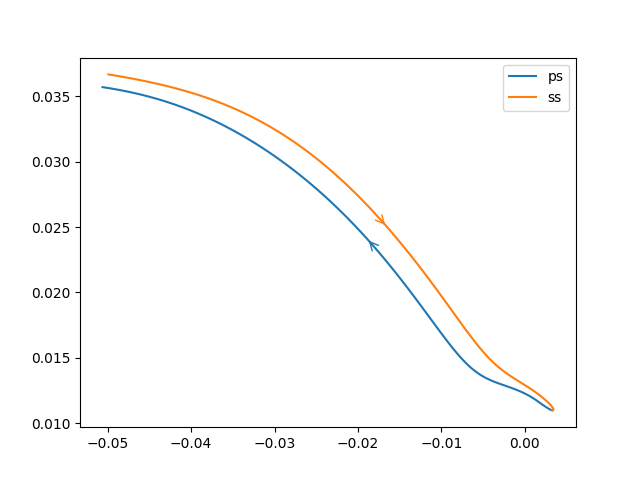

In [14]:
%matplotlib widget

ps_line = plt.plot(section[0, :, 0], section[0, :, 1], label='ps')
ss_line = plt.plot(section[1, :, 0], section[1, :, 1], label='ss')

add_arrow(ps_line[0])
add_arrow(ss_line[0])

plt.legend()
plt.show()

In [15]:
assert (section[0, 0, :] == section[1, -1, :]).all(), 'Error'

In [16]:
LE_POINTS = 15

In [17]:
ss = section[1, :-LE_POINTS, :]
ss_le = section[1, -LE_POINTS - 1:, :]

ps_le = section[0, :LE_POINTS + 1, :]
ps = section[0, LE_POINTS:, :]

In [18]:
ss_le.shape, ps_le.shape

((16, 3), (16, 3))

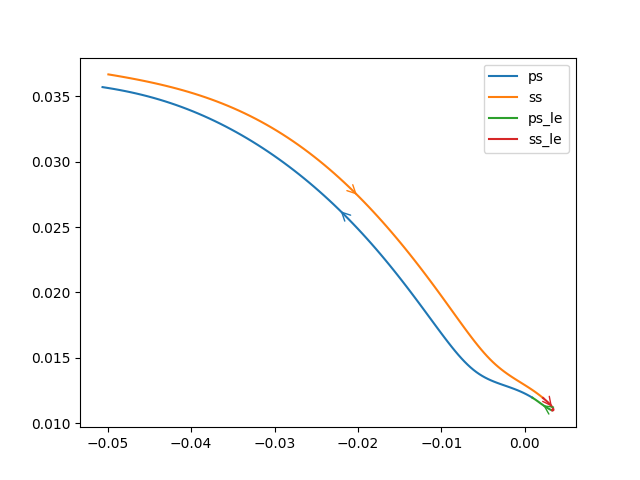

In [19]:
%matplotlib widget

ps_line = plt.plot(ps[:, 0], ps[:, 1], label='ps')
ss_line = plt.plot(ss[:, 0], ss[:, 1], label='ss')
ps_line_le = plt.plot(ps_le[:, 0], ps_le[:, 1], label='ps_le')
ss_line_le = plt.plot(ss_le[:, 0], ss_le[:, 1], label='ss_le')

add_arrow(ps_line[0])
add_arrow(ss_line[0])
add_arrow(ps_line_le[0])
add_arrow(ss_line_le[0])

plt.legend()
plt.show()

In [20]:
ps_le_control_points = get_bezier_parameters(ps_le[:, 0], ps_le[:, 1], ps_le[:, 2], degree=6)
ps_le_bezier_x, ps_le_bezier_y, ps_le_bezier_z = bezier_curve(ps_le_control_points, nTimes=20)

ss_le_control_points = get_bezier_parameters(ss_le[:, 0], ss_le[:, 1], ss_le[:, 2], degree=6)
ss_le_bezier_x, ss_le_bezier_y, ss_le_bezier_z = bezier_curve(ss_le_control_points, nTimes=20)

ps_control_points = get_bezier_parameters(ps[:, 0], ps[:, 1], ps[:, 2], degree=7)
ps_bezier_x, ps_bezier_y, ps_bezier_z = bezier_curve(ps_control_points, nTimes=100)

ss_control_points = get_bezier_parameters(ss[:, 0], ss[:, 1], ss[:, 2], degree=7)
ss_bezier_x, ss_bezier_y, ss_bezier_z = bezier_curve(ss_control_points, nTimes=100)

In [21]:
ps_le_control_points = np.array(ps_le_control_points)

ss_le_control_points = np.array(ss_le_control_points)

ps_control_points = np.array(ps_control_points)

ss_control_points = np.array(ss_control_points)

In [22]:
ps_le_control_points.shape

(7, 3)

In [23]:
(ss_control_points[-1] == ss_le_control_points[0]).all() and (ss_le_control_points[-1] == ps_le_control_points[0]).all() and (ps_le_control_points[-1] == ps_control_points[0]).all()

True

In [24]:
import plotly.graph_objects as go

fig = go.Figure(data=[
                      go.Scatter3d(x=ps_le_control_points[:, 0], y=ps_le_control_points[:, 1], z=ps_le_control_points[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Control Points Ps LE'),
                      go.Scatter3d(x=ps_le_bezier_x, y=ps_le_bezier_y, z=ps_le_bezier_z,
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Fitted curve Ps LE'),
                      go.Scatter3d(x=ps_le[:, 0], y=ps_le[:, 1], z=ps_le[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Original curve Ps LE'),

                      go.Scatter3d(x=ss_le_control_points[:, 0], y=ss_le_control_points[:, 1], z=ss_le_control_points[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Control Points Ss LE'),
                      go.Scatter3d(x=ss_le_bezier_x, y=ss_le_bezier_y, z=ss_le_bezier_z,
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Fitted curve Ss LE'),
                      go.Scatter3d(x=ss_le[:, 0], y=ss_le[:, 1], z=ss_le[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Original curve Ss LE'),
                    
                      go.Scatter3d(x=ps_control_points[:, 0], y=ps_control_points[:, 1], z=ps_control_points[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Control Points Ps'),
                      go.Scatter3d(x=ps_bezier_x, y=ps_bezier_y, z=ps_bezier_z,
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Fitted curve Ps'),
                      go.Scatter3d(x=ps[:, 0], y=ps[:, 1], z=ps[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Original curve Ps'),

                      go.Scatter3d(x=ss_control_points[:, 0], y=ss_control_points[:, 1], z=ss_control_points[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Control Points Ss'),
                      go.Scatter3d(x=ss_bezier_x, y=ss_bezier_y, z=ss_bezier_z,
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Fitted curve Ss'),
                      go.Scatter3d(x=ss[:, 0], y=ss[:, 1], z=ss[:, 2],
                                   mode='markers',
                                   marker=dict(size=5),
                                   name='Original curve Ss'),

],
                                   layout=go.Layout(
                            width=1000,
                            height=800,
                        ))
fig.show()

### Working with whole blades

In [25]:
inputFile = numecaParser()
inputFile.load(SAMPLE_PATH)
blade = inputFile.exportNpyArray(0, 0)[0]

In [26]:
bb = BezierBlade(blade, bezier_degree=[7, 6, 6, 7])
bb.fit_blade_with_bezier().shape

(11, 27, 3)

In [27]:
bb.set_evaluation_points([100, 20, 20, 100])
bb.get_blade_from_control_points().shape

(11, 240, 3)

In [28]:
bb.draw_blade()

In [29]:
blade = inputFile.exportNpyArray(1, 0)[0]
blade = np.flip(blade, axis=2)
blade.shape

(2, 11, 128, 4)

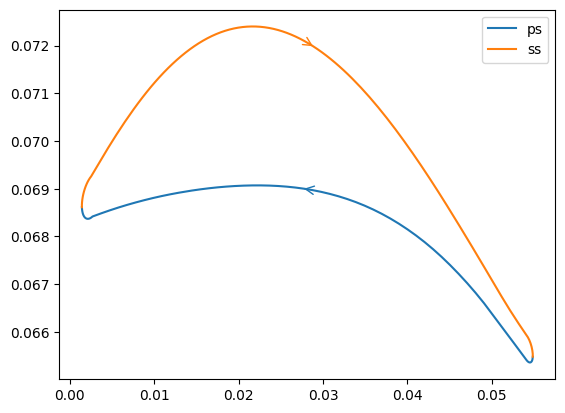

In [30]:
%matplotlib inline

section = blade[:, 0, :, :3]

ps_line = plt.plot(section[0, :, 0], section[0, :, 1], label='ps')
ss_line = plt.plot(section[1, :, 0], section[1, :, 1], label='ss')

add_arrow(ps_line[0])
add_arrow(ss_line[0])

plt.legend()
plt.show()

In [31]:
assert (section[0, 0, :] == section[1, -1, :]).all(), 'Error'

In [32]:
bb = BezierBlade(blade, bezier_degree=[6, 7, 6, 6, 7, 6], is_blunt_te=False)
bb.set_le_points_number(15)
bb.fit_blade_with_bezier().shape

(11, 38, 3)

In [33]:
bb.set_evaluation_points([20, 100, 20, 20, 100, 20])
bb.get_blade_from_control_points().shape

(11, 280, 3)

In [34]:
bb.draw_blade()

In [35]:
blade = inputFile.exportNpyArray(0, 0)[0]
bb = BezierBlade(blade, bezier_degree=[6, 7, 7, 6], is_blunt_te=True)
bb.set_le_points_number(15)
bb.fit_blade_with_bezier()
bb.add_noise(sigma=0.001)
bb.set_evaluation_points([100, 20, 20, 100])
bb.get_blade_from_control_points()
pass

In [36]:
bb.draw_blade()

### Whole Compressor

In [37]:
bc = BezierCompressor(SAMPLE_PATH, [[7, 6, 6, 7], [7, 6, 6, 7], [6, 7, 6, 6, 7, 6]], [True, True, False], [[100, 20, 20, 100], [100, 20, 20, 100], [20, 100, 20, 20, 100, 20]])
bc.fit_compressor_with_bezier()
bc.get_compressor_from_control_points()

In [38]:
bc.main_blade.draw_blade()

In [39]:
bc.splitter.draw_blade()

In [40]:
bc.diffuser.draw_blade()